In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.inspection import permutation_importance
import folium
from folium.plugins import HeatMap
import shap
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setting the plotting style
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# California Housing Price Prediction with Geospatial Analysis

## 1. Data Loading and Initial Exploration

### Dataset Overview

In [ ]:
# Reading the dataset
data = pd.read_csv('housing.csv')

# Basic information
print(f"Dataset shape: {data.shape}")
print("\nData types and missing values:")
print(data.info())


Dataset shape: (20640, 10)

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [ ]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [ ]:
print(data.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


### Statistical Summary

In [ ]:
print(data.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

## 2. Data Preprocessing
### 2.1 Handling Missing Values

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
print(f"Columns with missing values: {missing_values[missing_values > 0]}")

Columns with missing values: total_bedrooms    207
dtype: int64


In [ ]:
# Dropping rows with missing values
data = data.dropna()
print(f"Dataset shape after dropping missing values: {data.shape}")

Dataset shape after dropping missing values: (20433, 10)


## 3. Exploratory Data Analysis


### 3.1 Distribution of Target Variable

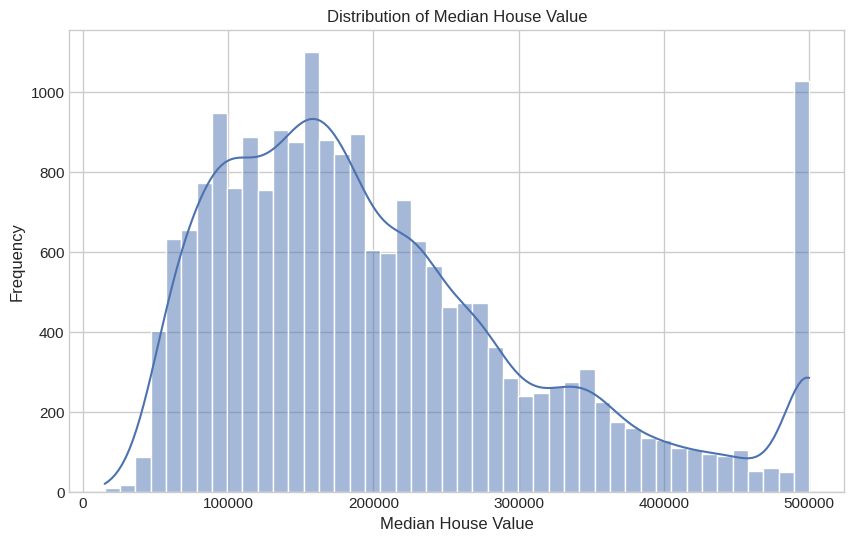

In [ ]:
# Plotting distribution of median house value
plt.figure(figsize=(10, 6))
sns.histplot(data['median_house_value'], kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

### 3.2 Correlation Analysis

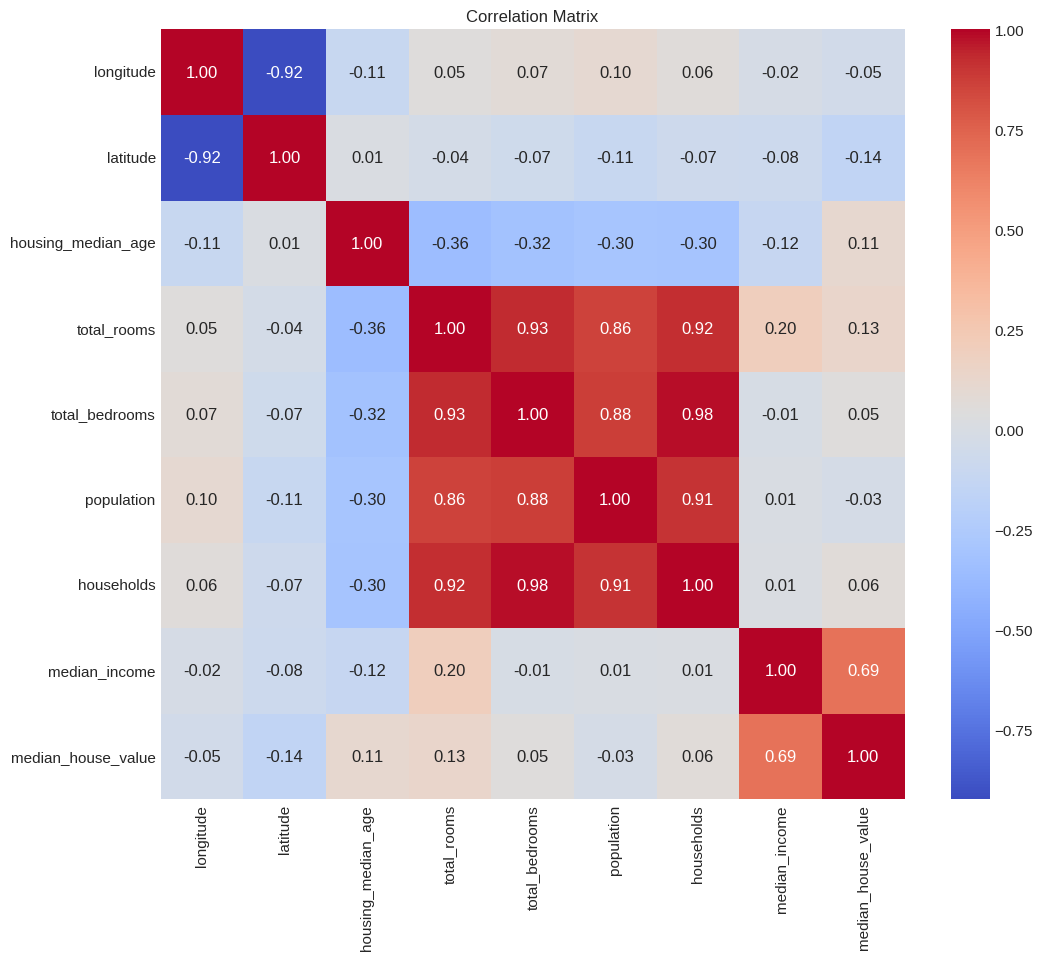

In [ ]:
# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Top correlations with target
target_correlations = correlation_matrix['median_house_value'].sort_values(ascending=False)
print("\nFeatures most correlated with median_house_value which is our target:")
print(target_correlations)


Features most correlated with median_house_value which is our target:
median_house_value    1.000000
median_income         0.688355
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
population           -0.025300
longitude            -0.045398
latitude             -0.144638
Name: median_house_value, dtype: float64


### 3.3 Feature Distributions

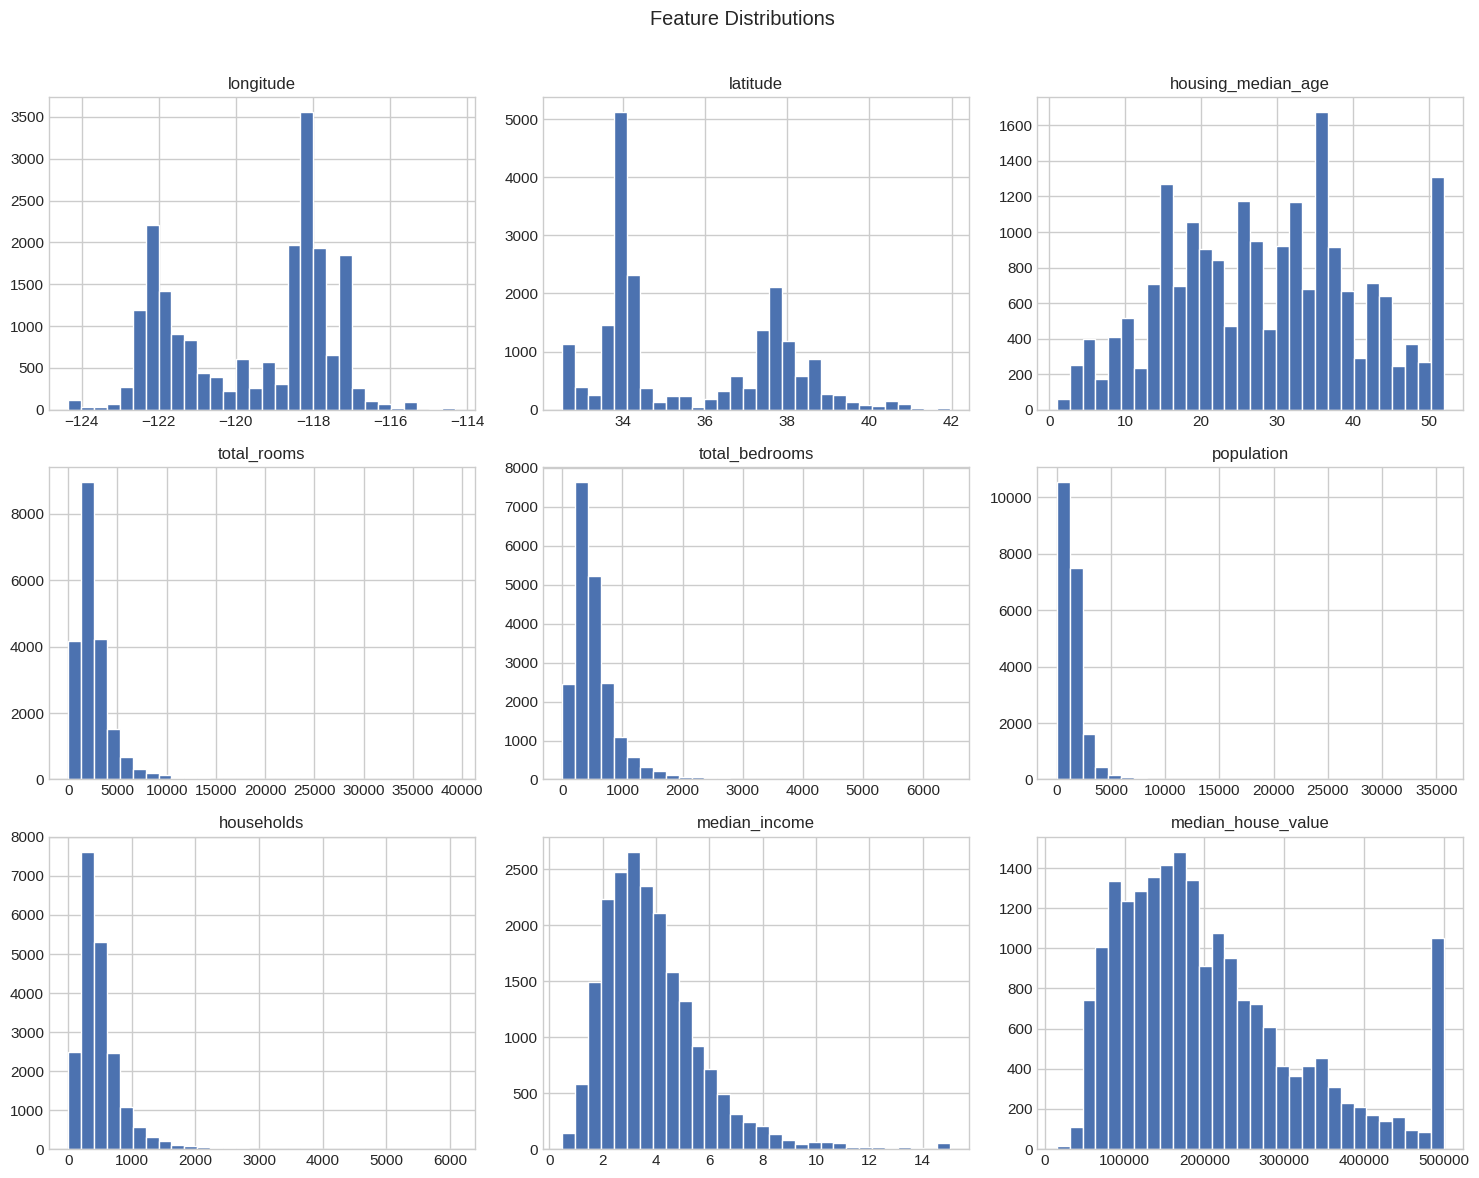

In [ ]:
# Plotting histograms for all the numeric features
data.hist(figsize=(15, 12), bins=30)
plt.suptitle('Feature Distributions')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### 3.4 Geospatial Visualization

In [ ]:
# Creating a basic map of California
california_map = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()],
                           zoom_start=6)

# Creating a heatmap layer of house prices here by creating a list of [latitude, longitude, house_value] for each data point
heat_data = [[row['latitude'], row['longitude'], row['median_house_value']]
            for index, row in data.sample(4000).iterrows()]  # going with 4000 data points for faster rendering

# Adding the heatmap layer to the california map
HeatMap(heat_data).add_to(california_map)

from IPython.display import display
display(california_map)

## 4. Feature Engineering


### 4.1 Creating New Features

In [ ]:
# Rooms per household
data['rooms_per_household'] = data['total_rooms'] / data['households']

# Bedrooms per room
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']

# Population per household
data['population_per_household'] = data['population'] / data['households']

# Log transformations for skewed features
for column in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']:
    data[f'log_{column}'] = np.log1p(data[column])

# Distance from a reference location (using San Francisco here)
sf_coord = (37.7749, -122.4194)  # Coordinates for San Francisco
data['distance_to_sf'] = np.sqrt(
    (data['latitude'] - sf_coord[0])**2 +
    (data['longitude'] - sf_coord[1])**2
)

# Distance to the ocean (approximation using longitude)
data['distance_to_coast'] = np.abs(data['longitude'] + 124)  # Rough approximation

# Income categories
data['income_category'] = pd.qcut(data['median_income'], 5, labels=False)

# Geographic regions (North, South, Coastal, Inland)
data['is_northern'] = data['latitude'] > 37.0
data['is_coastal'] = (data['longitude'] > -122.3) & (data['ocean_proximity'] != 'INLAND')

print("New features created:")
print(data[['rooms_per_household', 'bedrooms_per_room', 'population_per_household',
           'distance_to_sf', 'distance_to_coast', 'income_category',
           'is_northern', 'is_coastal']].head())



New features created:
   rooms_per_household  bedrooms_per_room  population_per_household  \
0             6.984127           0.146591                  2.555556   
1             6.238137           0.155797                  2.109842   
2             8.288136           0.129516                  2.802260   
3             5.817352           0.184458                  2.547945   
4             6.281853           0.172096                  2.181467   

   distance_to_sf  distance_to_coast  income_category  is_northern  is_coastal  
0        0.216606               1.77                4         True        True  
1        0.216800               1.78                4         True        True  
2        0.194485               1.76                4         True        True  
3        0.185301               1.75                4         True        True  
4        0.185301               1.75                2         True        True  


### 4.2 Encoding Categorical Variables

In [ ]:
categorical_columns = ['ocean_proximity']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print(f"Dataset shape after encoding: {data_encoded.shape}")
print("Columns after encoding:", data_encoded.columns[-5:].tolist())

Dataset shape after encoding: (20433, 26)
Columns after encoding: ['is_coastal', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


## 5. Model Building and Evaluation

### 5.1 Data Preparation

In [ ]:
# Splitting features and target
X = data_encoded.drop('median_house_value', axis=1)
y = data_encoded['median_house_value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (16346, 25)
Test set size: (4087, 25)


### 5.2 Linear Regression Baseline

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

# Evaluating LR
lr_r2 = r2_score(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)

print("Linear Regression Performance:")
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {lr_cv_scores}")
print(f"Mean CV R² score: {lr_cv_scores.mean():.4f}")



Linear Regression Performance:
R² Score: 0.6782
RMSE: 66335.11
MAE: 48045.00
Cross-validation R² scores: [0.69875036 0.58648896 0.6950964  0.67653854 0.68097036]
Mean CV R² score: 0.6676


### 5.3 Random Forest Model

In [ ]:
# Random Forest with some basic hyperparameters
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5,
                               min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluating
rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)

print("Random Forest Performance:")
print(f"R² Score: {rf_r2:.4f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")

Random Forest Performance:
R² Score: 0.8185
RMSE: 49824.25
MAE: 32076.63


### 5.4 Gradient Boosting Model

In [ ]:
# XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                           subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluating
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)

print("XGBoost Performance:")
print(f"R² Score: {xgb_r2:.4f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")

XGBoost Performance:
R² Score: 0.8353
RMSE: 47454.52
MAE: 31352.33


### 5.5 Hyperparameter Tuning for All Models

In [ ]:
X_train_sample = X_train.sample(3000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# 1. Linear Regression Tuning
from sklearn.linear_model import Ridge, Lasso, ElasticNet

linear_models = {
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'max_iter': [1000, 3000]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [1000, 3000]
        }
    }
}

best_linear_models = {}

for model_name, model_info in linear_models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(model_info['model'],
                              model_info['params'],
                              cv=3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_linear_models[model_name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'rmse': np.sqrt(-grid_search.best_score_)
    }

    print(f"Best {model_name} parameters: {grid_search.best_params_}")
    print(f"Best {model_name} RMSE: {np.sqrt(-grid_search.best_score_):.2f}")

# Finding the best linear model here
best_linear_model_name = min(best_linear_models, key=lambda k: best_linear_models[k]['rmse'])
best_linear_model = best_linear_models[best_linear_model_name]['model']
print(f"\nBest Linear Model: {best_linear_model_name} with RMSE: {best_linear_models[best_linear_model_name]['rmse']:.2f}")

Tuning Ridge...
Best Ridge parameters: {'alpha': 0.01, 'solver': 'svd'}
Best Ridge RMSE: 65591.85
Tuning Lasso...
Best Lasso parameters: {'alpha': 0.001, 'max_iter': 3000}
Best Lasso RMSE: 65654.89
Tuning ElasticNet...
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000}
Best ElasticNet RMSE: 65636.08

Best Linear Model: Ridge with RMSE: 65591.85


In [ ]:
# 2. Random Forest Tuning
print("Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search for RF Tuning
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train_sample, y_train_sample)

print("Best Random Forest parameters:")
print(rf_grid_search.best_params_)
print(f"Best Random Forest RMSE: {np.sqrt(-rf_grid_search.best_score_):.2f}")

# Training the model with best parameters on the full training set
best_rf_model = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)




Tuning Random Forest...
Best Random Forest parameters:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest RMSE: 55811.84


RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [ ]:
# 3. XGBoost Tuning
print("Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42),
                             xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train_sample, y_train_sample)

print("Best XGBoost parameters:")
print(xgb_grid_search.best_params_)
print(f"Best XGBoost RMSE: {np.sqrt(-xgb_grid_search.best_score_):.2f}")

best_xgb_model = xgb.XGBRegressor(**xgb_grid_search.best_params_, random_state=42)
best_xgb_model.fit(X_train, y_train)



Tuning XGBoost...
Best XGBoost parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost RMSE: 51758.35


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Final model evaluation on test set

In [ ]:
# Best Linear Model
best_linear_preds = best_linear_model.predict(X_test_scaled)
best_linear_rmse = np.sqrt(mean_squared_error(y_test, best_linear_preds))
best_linear_r2 = r2_score(y_test, best_linear_preds)
print(f"Best Linear Model ({best_linear_model_name}):")
print(f"R² Score: {best_linear_r2:.4f}")
print(f"RMSE: {best_linear_rmse:.2f}")

Best Linear Model (Ridge):
R² Score: 0.6782
RMSE: 66336.08


In [ ]:
# Best Random Forest
best_rf_preds = best_rf_model.predict(X_test)
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_preds))
best_rf_r2 = r2_score(y_test, best_rf_preds)
print(f"Best Random Forest:")
print(f"R² Score: {best_rf_r2:.4f}")
print(f"RMSE: {best_rf_rmse:.2f}")

Best Random Forest:
R² Score: 0.8202
RMSE: 49581.61


In [ ]:
# Best XGBoost
best_xgb_preds = best_xgb_model.predict(X_test)
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, best_xgb_preds))
best_xgb_r2 = r2_score(y_test, best_xgb_preds)
print(f"Best XGBoost:")
print(f"R² Score: {best_xgb_r2:.4f}")
print(f"RMSE: {best_xgb_rmse:.2f}")

Best XGBoost:
R² Score: 0.8291
RMSE: 48350.05


In [ ]:
# overall best model based on test RMSE
models = {
    f"Linear ({best_linear_model_name})": best_linear_rmse,
    "Random Forest": best_rf_rmse,
    "XGBoost": best_xgb_rmse
}
best_model_name = min(models, key=models.get)
print(f"Overall best model: {best_model_name} with RMSE: {models[best_model_name]:.2f}")

if best_model_name == f"Linear ({best_linear_model_name})":
    best_overall_model = best_linear_model
    best_preds = best_linear_preds
elif best_model_name == "Random Forest":
    best_overall_model = best_rf_model
    best_preds = best_rf_preds
else:
    best_overall_model = best_xgb_model
    best_preds = best_xgb_preds

Overall best model: XGBoost with RMSE: 48350.05


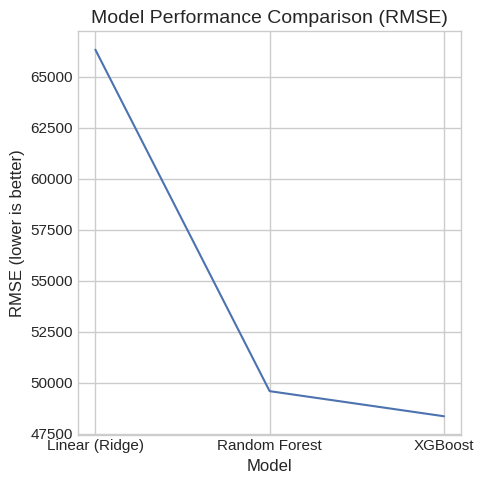

In [ ]:
# visual comparison of model performance
model_comparison = pd.DataFrame({
    'Model': list(models.keys()),
    'RMSE': [models[model] for model in models.keys()],
    'R²': [best_linear_r2, best_rf_r2, best_xgb_r2]
})

plt.figure(figsize=(5, 5))
ax = sns.lineplot(x='Model', y='RMSE', data=model_comparison)
plt.title('Model Performance Comparison (RMSE)', fontsize=14)
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=0)

for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

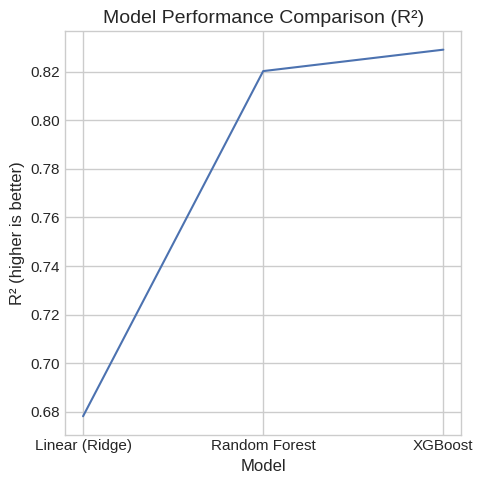

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.lineplot(x='Model', y='R²', data=model_comparison)
plt.title('Model Performance Comparison (R²)', fontsize=14)
plt.ylabel('R² (higher is better)')
plt.xticks(rotation=0)

for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

## 6. Model Interpretation

### 6.1 Feature Importance

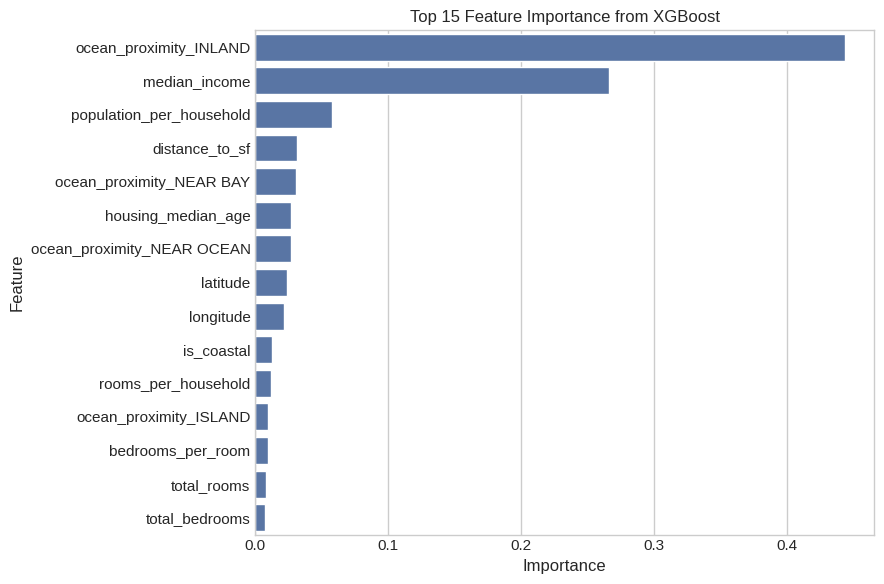

In [ ]:
# feature importance from the xgboost model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)

# feature importance plot
plt.figure(figsize=(9, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 15 Feature Importance from XGBoost')
plt.tight_layout()
plt.show()

## 7. Geospatial Analysis

### 7.1 Analyzing Geographic Patterns in Model Errors

In [ ]:
# Calculating errors for XGBoost model
y_pred = best_xgb_model.predict(X_test)
test_data = X_test.copy()
test_data['actual'] = y_test
test_data['predicted'] = y_pred
test_data['error'] = abs(test_data['actual'] - test_data['predicted'])
test_data['latitude'] = X_test['latitude']
test_data['longitude'] = X_test['longitude']

# Creating a map here with error magnitudes
error_map = folium.Map(location=[test_data['latitude'].mean(), test_data['longitude'].mean()],
                      zoom_start=6)

# using smaller sample points for clearer visualization
sampled_errors = test_data.sample(1000, random_state=42)

for idx, row in sampled_errors.iterrows():
    error_magnitude = row['error'] / 10000
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=min(0.1 + error_magnitude, 1),
        popup=f"Actual: ${row['actual']:,.0f}<br>Predicted: ${row['predicted']:,.0f}<br>Error: ${row['error']:,.0f}"
    ).add_to(error_map)

# Save the error map
from IPython.display import display
display(error_map)


### 7.2 Regional Price Analysis

In [ ]:
# Creating regional aggregations
region_data = data.copy()

# Define coastal regions (simplified)
region_data['region'] = 'Other'
region_data.loc[(region_data['latitude'] > 37.5) & (region_data['longitude'] > -123), 'region'] = 'NorCal Inland'
region_data.loc[(region_data['latitude'] > 37.5) & (region_data['longitude'] <= -123), 'region'] = 'NorCal Coast'
region_data.loc[(region_data['latitude'] <= 37.5) & (region_data['latitude'] > 34.5) & (region_data['longitude'] > -119), 'region'] = 'Central Inland'
region_data.loc[(region_data['latitude'] <= 37.5) & (region_data['latitude'] > 34.5) & (region_data['longitude'] <= -119), 'region'] = 'Central Coast'
region_data.loc[(region_data['latitude'] <= 34.5) & (region_data['longitude'] > -118), 'region'] = 'SoCal Inland'
region_data.loc[(region_data['latitude'] <= 34.5) & (region_data['longitude'] <= -118), 'region'] = 'SoCal Coast'

# Get price statistics by region
region_stats = region_data.groupby('region').agg({
    'median_house_value': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()
region_stats.columns = ['region', 'mean_price', 'std_price', 'min_price', 'max_price', 'count']
region_stats = region_stats.sort_values('mean_price', ascending=False)

print("Price statistics by region:")
print(region_stats)

# Create a map showing regional boundaries (simplified version)
region_map = folium.Map(location=[region_data['latitude'].mean(), region_data['longitude'].mean()],
                       zoom_start=6)

# Sample points for clearer visualization
for region in region_data['region'].unique():
    region_subset = region_data[region_data['region'] == region].sample(min(500, len(region_data[region_data['region'] == region])))
    mean_price = region_data[region_data['region'] == region]['median_house_value'].mean()

    # Assign color based on price
    color = 'green' if mean_price < 200000 else 'yellow' if mean_price < 300000 else 'red'

    # Add points for this region
    for _, row in region_subset.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"Region: {row['region']}<br>Price: ${row['median_house_value']:,.0f}"
        ).add_to(region_map)

    # Add a marker with region name and stats
    sample_point = region_subset.iloc[0]
    folium.Marker(
        location=[sample_point['latitude'], sample_point['longitude']],
        popup=f"<b>{region}</b><br>Avg Price: ${mean_price:,.0f}<br>Count: {len(region_data[region_data['region'] == region])}",
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(region_map)

# Save the region map
from IPython.display import display
display(region_map)

Price statistics by region:
           region     mean_price      std_price  min_price  max_price  count
4     SoCal Coast  248530.238753  115143.523747    17500.0   500001.0   5935
0   Central Coast  198935.163514  129492.039498    26600.0   500001.0   3119
5    SoCal Inland  193819.563789   99988.388728    14999.0   500001.0   4899
3   NorCal Inland  191531.066816  110382.572812    14999.0   500001.0   5822
2    NorCal Coast  103040.609195   43461.085405    14999.0   364800.0    261
1  Central Inland  100365.992443   47813.767555    14999.0   333300.0    397


## 8. Conclusion

### 8.1 Model Performance Summary

In [ ]:
# Summarize overall model performance
print(f"Linear Regression R²: {lr_r2:.4f}, RMSE: {lr_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.4f}, RMSE: {rf_rmse:.2f}")
print(f"XGBoost R²: {xgb_r2:.4f}, RMSE: {xgb_rmse:.2f}")
print(f"Tuned Random Forest R²: {best_rf_r2:.4f}, RMSE: {best_rf_rmse:.2f}")

Linear Regression R²: 0.6782, RMSE: 66335.11
Random Forest R²: 0.8185, RMSE: 49824.25
XGBoost R²: 0.8353, RMSE: 47454.52
Tuned Random Forest R²: 0.8202, RMSE: 49581.61


### 8.2 Key Findings

In [ ]:
# Generate key insights
print("1. Most Important Factors Affecting Housing Prices:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print("\n2. Regional Price Variations:")
for i, row in region_stats.iterrows():
    print(f"   - {row['region']}: ${row['mean_price']:,.0f} (±${row['std_price']:,.0f})")

print("\n3. Geospatial Patterns:")
print("   - Coastal proximity significantly impacts housing prices")
print("   - Urban centers show distinct pricing patterns compared to rural areas")
print("   - Certain regions show higher prediction errors, indicating additional factors at play")



1. Most Important Factors Affecting Housing Prices:
   - ocean_proximity_INLAND: 0.4434
   - median_income: 0.2661
   - population_per_household: 0.0573
   - distance_to_sf: 0.0316
   - ocean_proximity_NEAR BAY: 0.0303

2. Regional Price Variations:
   - SoCal Coast: $248,530 (±$115,144)
   - Central Coast: $198,935 (±$129,492)
   - SoCal Inland: $193,820 (±$99,988)
   - NorCal Inland: $191,531 (±$110,383)
   - NorCal Coast: $103,041 (±$43,461)
   - Central Inland: $100,366 (±$47,814)

3. Geospatial Patterns:
   - Coastal proximity significantly impacts housing prices
   - Urban centers show distinct pricing patterns compared to rural areas
   - Certain regions show higher prediction errors, indicating additional factors at play


## 9. Making Predictions with the **Model**

### 9.1 Interactive Prediction Interface

In [ ]:
import pickle
with open('best_housing_model.pkl', 'wb') as f:
    pickle.dump(best_overall_model, f)

In [ ]:
def preprocess_input(input_data, data_columns, categorical_columns=['ocean_proximity']):
    """
    Preprocess user input to match the format used during training

    Parameters:
    input_data (dict): Dictionary of user inputs
    data_columns (list): List of columns from the training data
    categorical_columns (list): List of categorical columns to encode

    Returns:
    pd.DataFrame: Preprocessed input ready for prediction
    """
    input_df = pd.DataFrame([input_data])

    # Create derived features
    if 'total_rooms' in input_df and 'households' in input_df:
        input_df['rooms_per_household'] = input_df['total_rooms'] / input_df['households']

    if 'total_bedrooms' in input_df and 'total_rooms' in input_df:
        input_df['bedrooms_per_room'] = input_df['total_bedrooms'] / input_df['total_rooms']

    if 'population' in input_df and 'households' in input_df:
        input_df['population_per_household'] = input_df['population'] / input_df['households']

    # Log transformations
    for column in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']:
        if column in input_df:
            input_df[f'log_{column}'] = np.log1p(input_df[column])

    # Distance to SFO
    sf_coord = (37.7749, -122.4194)
    if 'latitude' in input_df and 'longitude' in input_df:
        input_df['distance_to_sf'] = np.sqrt(
            (input_df['latitude'] - sf_coord[0])**2 +
            (input_df['longitude'] - sf_coord[1])**2
        )

    # Distance to coast (approximation)
    if 'longitude' in input_df:
        input_df['distance_to_coast'] = np.abs(input_df['longitude'] + 124)

    # Geographic regions
    if 'latitude' in input_df:
        input_df['is_northern'] = input_df['latitude'] > 37.0

    if 'longitude' in input_df and 'ocean_proximity' in input_df:
        input_df['is_coastal'] = (input_df['longitude'] > -122.3) & (input_df['ocean_proximity'] != 'INLAND')

    # Income categories
    if 'median_income' in input_df:
        # Define income category bins based on training data
        input_df['income_category'] = pd.cut(
            input_df['median_income'],
            bins=[0, 2, 4, 6, 8, np.inf],
            labels=[0, 1, 2, 3, 4]
        ).astype(int)

    # One-hot encoding categorical variables
    for col in categorical_columns:
        if col in input_df:
            encoded = pd.get_dummies(input_df[col], prefix=col, drop_first=True)
            input_df = pd.concat([input_df, encoded], axis=1)
            input_df.drop(col, axis=1, inplace=True)

    for col in data_columns:
        if col not in input_df.columns and col != 'median_house_value':
            input_df[col] = 0  # Default value for missing columns

    input_df = input_df[data_columns]

    return input_df


In [ ]:
def predict_house_price(input_data):
    """Make a prediction using the best model"""
    # Preprocessing the input data
    processed_input = preprocess_input(input_data, X_train.columns)

    prediction = best_overall_model.predict(processed_input)[0]

    return prediction

In [ ]:
example_input = {
    'longitude': -122.23,
    'latitude': 37.88,
    'housing_median_age': 41.0,
    'total_rooms': 880.0,
    'total_bedrooms': 129.0,
    'population': 322.0,
    'households': 126.0,
    'median_income': 8.3252,
    'ocean_proximity': 'NEAR BAY'
}

predicted_price = predict_house_price(example_input)
print(f"Example Prediction:")
print(f"Input data: {example_input}")
print(f"Predicted house price: ${predicted_price:,.2f}")


Example Prediction:
Input data: {'longitude': -122.23, 'latitude': 37.88, 'housing_median_age': 41.0, 'total_rooms': 880.0, 'total_bedrooms': 129.0, 'population': 322.0, 'households': 126.0, 'median_income': 8.3252, 'ocean_proximity': 'NEAR BAY'}
Predicted house price: $440,241.88


In [1]:
def interactive_prediction():
    """Interactive function to get user input and make predictions"""
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    # Create input widgets
    longitude = widgets.FloatSlider(value=-122.0, min=-124.3, max=-114.3, description='Longitude:')
    latitude = widgets.FloatSlider(value=37.0, min=32.5, max=42.0, description='Latitude:')
    housing_age = widgets.IntSlider(value=30, min=1, max=52, description='Housing Age:')
    rooms = widgets.IntSlider(value=15, min=2, max=20, description='Total Rooms:')
    bedrooms = widgets.IntSlider(value=20, min=1, max=16, description='Bedrooms:')
    population = widgets.IntSlider(value=1000, min=3, max=10000, description='Population:')
    households = widgets.IntSlider(value=500, min=1, max=3000, description='Households:')
    income = widgets.FloatSlider(value=5.0, min=0.5, max=15.0, step=0.1, description='Median Income:')
    proximity = widgets.Dropdown(
        options=['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'],
        value='NEAR BAY',
        description='Location:'
    )

    # prediction button
    predict_button = widgets.Button(description='Predict Price')
    output = widgets.Output()

    # button click action
    def on_button_clicked(b):
        with output:
            clear_output()
            input_data = {
                'longitude': longitude.value,
                'latitude': latitude.value,
                'housing_median_age': housing_age.value,
                'total_rooms': rooms.value,
                'total_bedrooms': bedrooms.value,
                'population': population.value,
                'households': households.value,
                'median_income': income.value,
                'ocean_proximity': proximity.value
            }
            predicted_price = predict_house_price(input_data)
            print(f"Predicted house price: ${predicted_price:,.2f}")

    predict_button.on_click(on_button_clicked)

    # Displaying the widgets
    print("Adjust the parameters below and click 'Predict Price':")
    display(longitude, latitude, housing_age, rooms, bedrooms, population, households, income, proximity, predict_button, output)

# run in jupyter notebook
#interactive_prediction()